<a href="https://colab.research.google.com/github/calcoach/covidStatistics/blob/master/Statistics_covid2019.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Estadisticas Covid19 Colombia


#Instalar sodapy


In [3]:
!pip install sodapy

#Obtener JSON con la data

Llama a la api de datos.gov con el json de datos de casos positivos covid19 



In [4]:

import pandas as pd
from sodapy import Socrata

# Unauthenticated client only works with public data sets. Note 'None'
# in place of application token, and no username or password:
client = Socrata("www.datos.gov.co", None)

# Example authenticated client (needed for non-public datasets):
# client = Socrata(www.datos.gov.co,
#                  MyAppToken,
#                  userame="user@example.com",
#                  password="AFakePassword")

# First 2000 results, returned as JSON from API / converted to Python list of
# dictionaries by sodapy.
dataset = "gt2j-8ykr"
count = client.get(dataset,select ="COUNT(*)")
count = count.pop()
limite = count['COUNT']
print('Limite: ' + str(limite))

results = client.get(dataset, limit = limite)

# Convert to pandas DataFrame
results_df = pd.DataFrame.from_records(results)

Limite: 190700


Obtiene un sumario de las columnas

In [5]:
#results_df.count()
results_df.describe()

,id_de_caso,fecha_de_notificaci_n,c_digo_divipola,ciudad_de_ubicaci_n,departamento,atenci_n,edad,sexo,tipo,estado,pa_s_de_procedencia,fis,fecha_diagnostico,fecha_recuperado,fecha_reporte_web,tipo_recuperaci_n,codigo_departamento,codigo_pais,pertenencia_etnica,nombre_grupo_etnico,fecha_de_muerte
count,190700,190700,190700,190700,190700,190700,190700,190700,190700,190700,952,190700,186975,85836,190700,85836,190700,875,85068,2748,6721
unique,190700,136,783,737,37,6,107,4,3,6,46,1279,132,126,132,2,36,39,6,60,120
top,116282,2020-07-03T00:00:00.000,11001,Bogotá D.C.,Bogotá D.C.,Casa,30,M,En estudio,Leve,ESPAÑA,Asintomático,2020-07-14T00:00:00.000,2020-07-18T00:00:00.000,2020-07-17T00:00:00.000,Tiempo,11,724,Otro,Por Definir,2020-07-07T00:00:00.000
freq,1,6128,60394,60394,60394,87121,5224,102298,172590,147016,264,24973,7537,4748,8934,47524,60394,259,71667,824,182


In [6]:
 #condition = results_df[results_df['estado'] == "Leve"]
 #print(condition.count)
import math
def truncate(number, digits) -> float:
    stepper = 10.0 ** digits
    return math.trunc(stepper * number) / stepper

total = len(results_df.index)
estados = pd.unique(results_df['estado'])

for estado in estados:
  #print(estado + ": " + str((results_df.estado == estado).sum())  )
  num = (results_df.estado == estado).sum()
  per = truncate((num * 100)/total,2)
  print('{}: {} {}%'.format(estado,num, per))

print("Total: "+ str(total))

print('\n')

print("Norte de Santander: "+str((results_df.departamento =='Norte de Santander').sum()))
print("Barranquilla: "+str((results_df.departamento =='Barranquilla D.E.').sum()))
print("Atlantico: "+str((results_df.departamento == "Atlantico").sum()))
 



Leve: 147016 77.09%
Asintomático: 24973 13.09%
Fallecido: 6516 3.41%
Moderado: 10733 5.62%
Grave: 1064 0.55%
N/A: 398 0.2%
Total: 190700


Norte de Santander: 790
Barranquilla: 24703
Atlantico: 0


# Grafica de Estados

Se genera una grafica pichart con los estados de los infectados de covid

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Unrecognized location 'left center'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


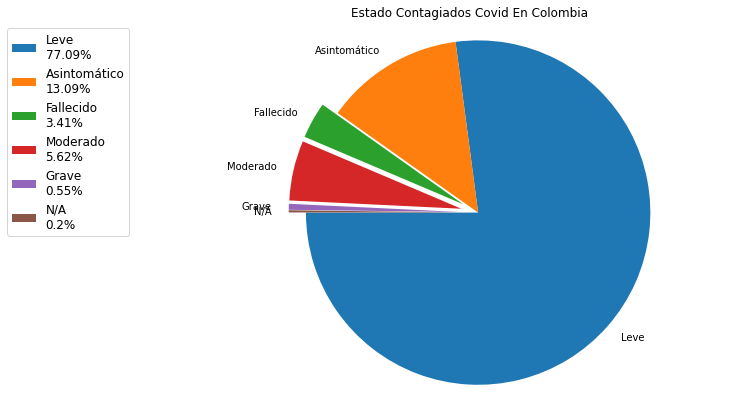

In [7]:
import matplotlib.pyplot as plt
import numpy as np

def func(label, pct, allvalues): 
    absolute = pct * 100/np.sum(allvalues)
    return "{}\n{}%".format(label, truncate(absolute,2)) 

explode = (0.0, 0.0, 0.1, 0.1, 0.1, 0.1) 
labels = pd.unique(results_df['estado'])
labels_with_percentage = []

estados = []

for label in labels:
  sum = (results_df.estado == label).sum()
  estados.append(sum)

for (label, estado) in zip(labels,estados):
    labels_with_percentage.append(func(label, estado, estados))

fig, ax = plt.subplots(figsize = (10, 7)) 

ax.pie(estados, explode=explode, labels=labels,  startangle=180)

plt.axis('equal') # Try commenting this out.
plt.title('Estado Contagiados Covid En Colombia')
plt.legend(labels_with_percentage, loc='left center', bbox_to_anchor=(-0.1, 1.),
              fontsize=12)

plt.show()

menores de un año


edad
(0, 10]      0.003146
(10, 20]     0.007341
(20, 30]     0.048768
(30, 40]     0.123755
(40, 50]     0.276350
(50, 60]     0.532774
(60, 70]     0.803356
(70, 80]     0.839539
(80, 90]     0.632931
(90, 100]    0.142632
Name: edad, dtype: float64

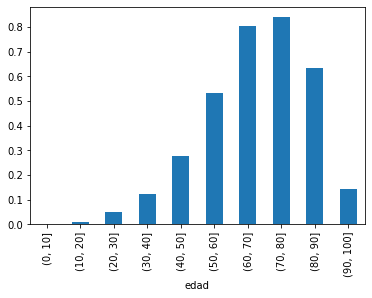

In [52]:



results_df['edad']=results_df['edad'].astype('int')
fallecidos = results_df[results_df.estado == 'Fallecido']

bins = [0,10,20,30,40,50,60,70,80,90,100]
rangos = fallecidos.groupby(pd.cut(fallecidos['edad'], bins=bins)).edad.count()*100/total
rangos.plot(kind='bar')

print('menores de un año')
hola



In [51]:
edad = 3
youns = results_df[results_df.edad == edad] 

j = pd.cut(results_df['edad'], bins=[0,10])

print(len(j.index))

total_youns = len(youns.index)

deads = (youns.estado == 'Fallecido').sum()

print('los jovenes infectados de {} son {} y los fallecidos: {} con un porcenyaje de muerte de: {} % '.format(edad,total_youns, deads, (deads*100/
                                                                                                                                total_youns)))

190700
los jovenes infectados de 3 son 657 y los fallecidos: 3 con un porcenyaje de muerte de: 0.45662100456621 % 
